# Auto Encoder

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()

import tensorflow
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

## Load dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Numerical/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
df.columns.values

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [5]:
df.shape

(284807, 31)

## Analysis

In [6]:
print("Distribuition of Normal(0) and Frauds(1): ")
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes

Distribuition of Normal(0) and Frauds(1): 


Class
0    284315
1       492
Name: count, dtype: int64

Text(0, 0.5, 'Fraquency')

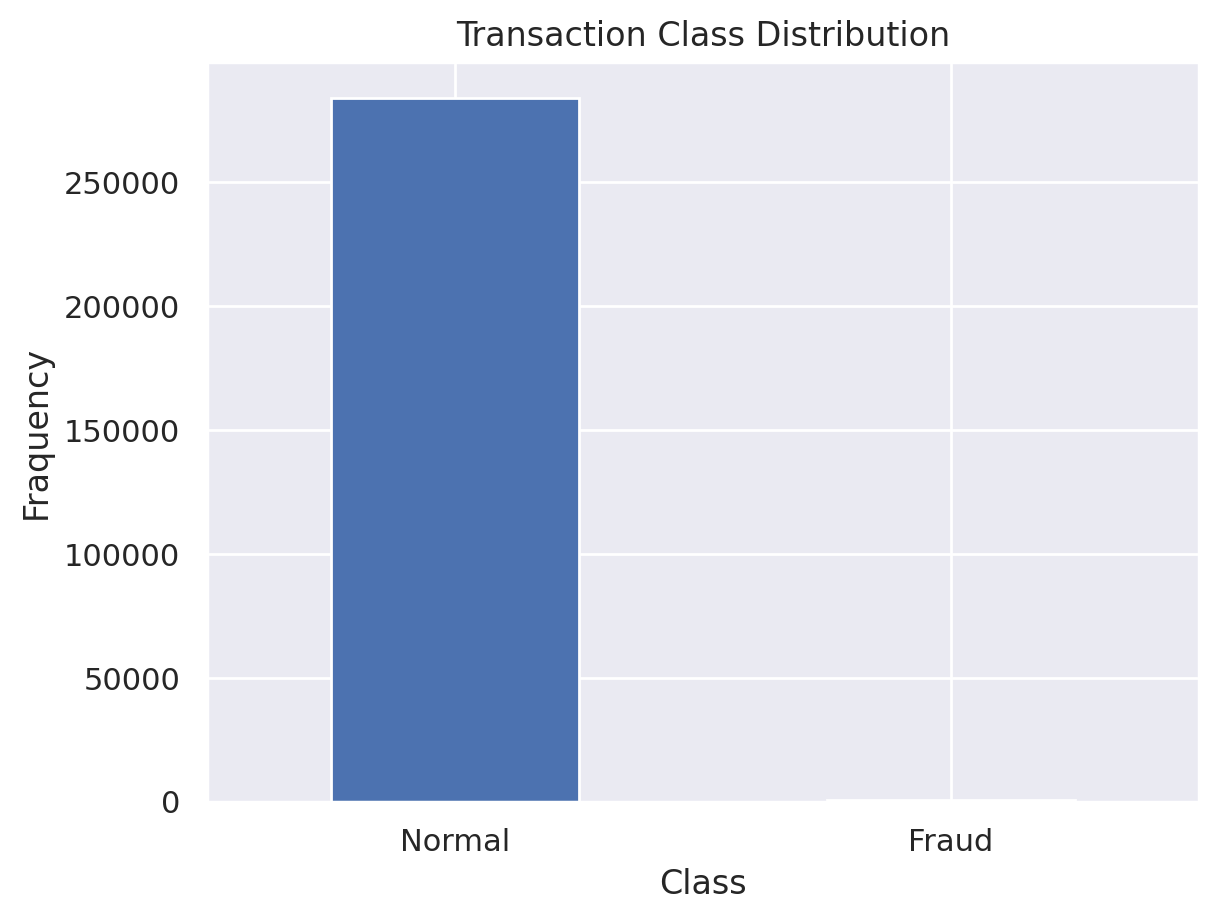

In [7]:
LABELS = ["Normal", "Fraud"]

count_classes.plot(kind="bar", rot=0)
plt.title("Transaction Class Distribution")
# Set labels on x-axis
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Fraquency")

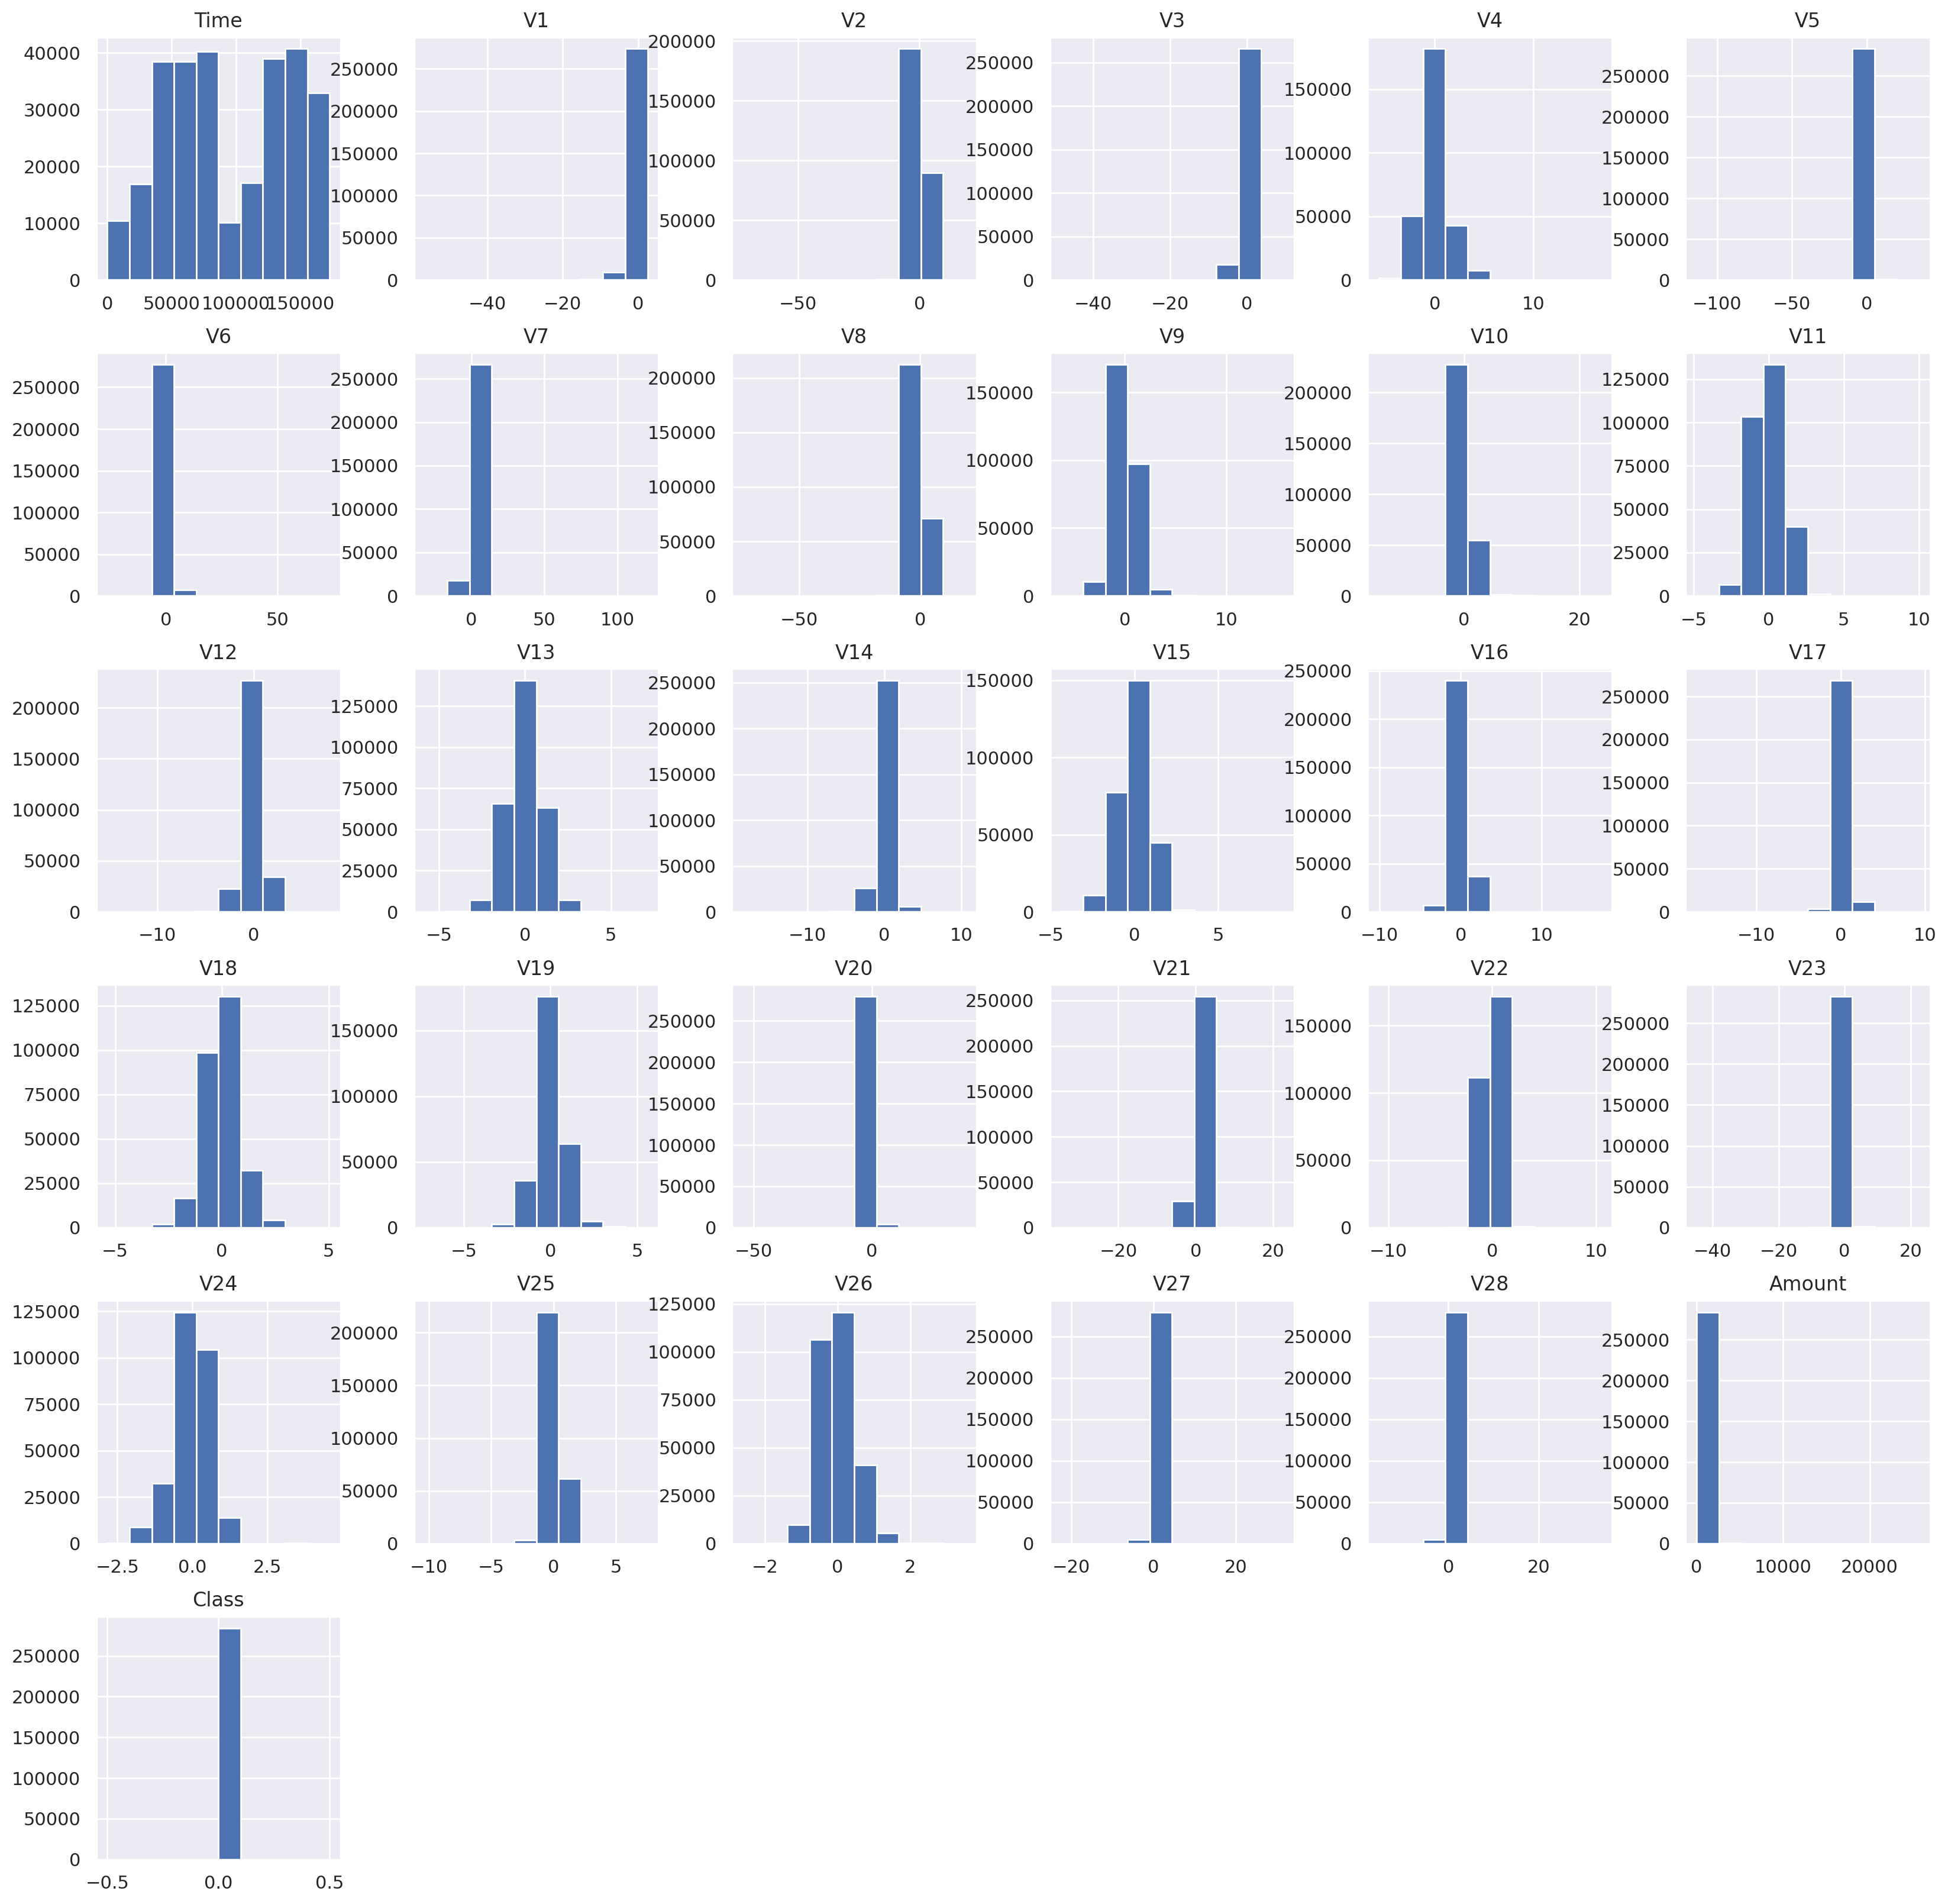

In [8]:
### Normal transaction
df[df.Class == 0].hist(figsize = (20,20))
plt.show()

here time is given in the seconds so we need to change that in minute and hour, and then we will do some feature selection

In [9]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

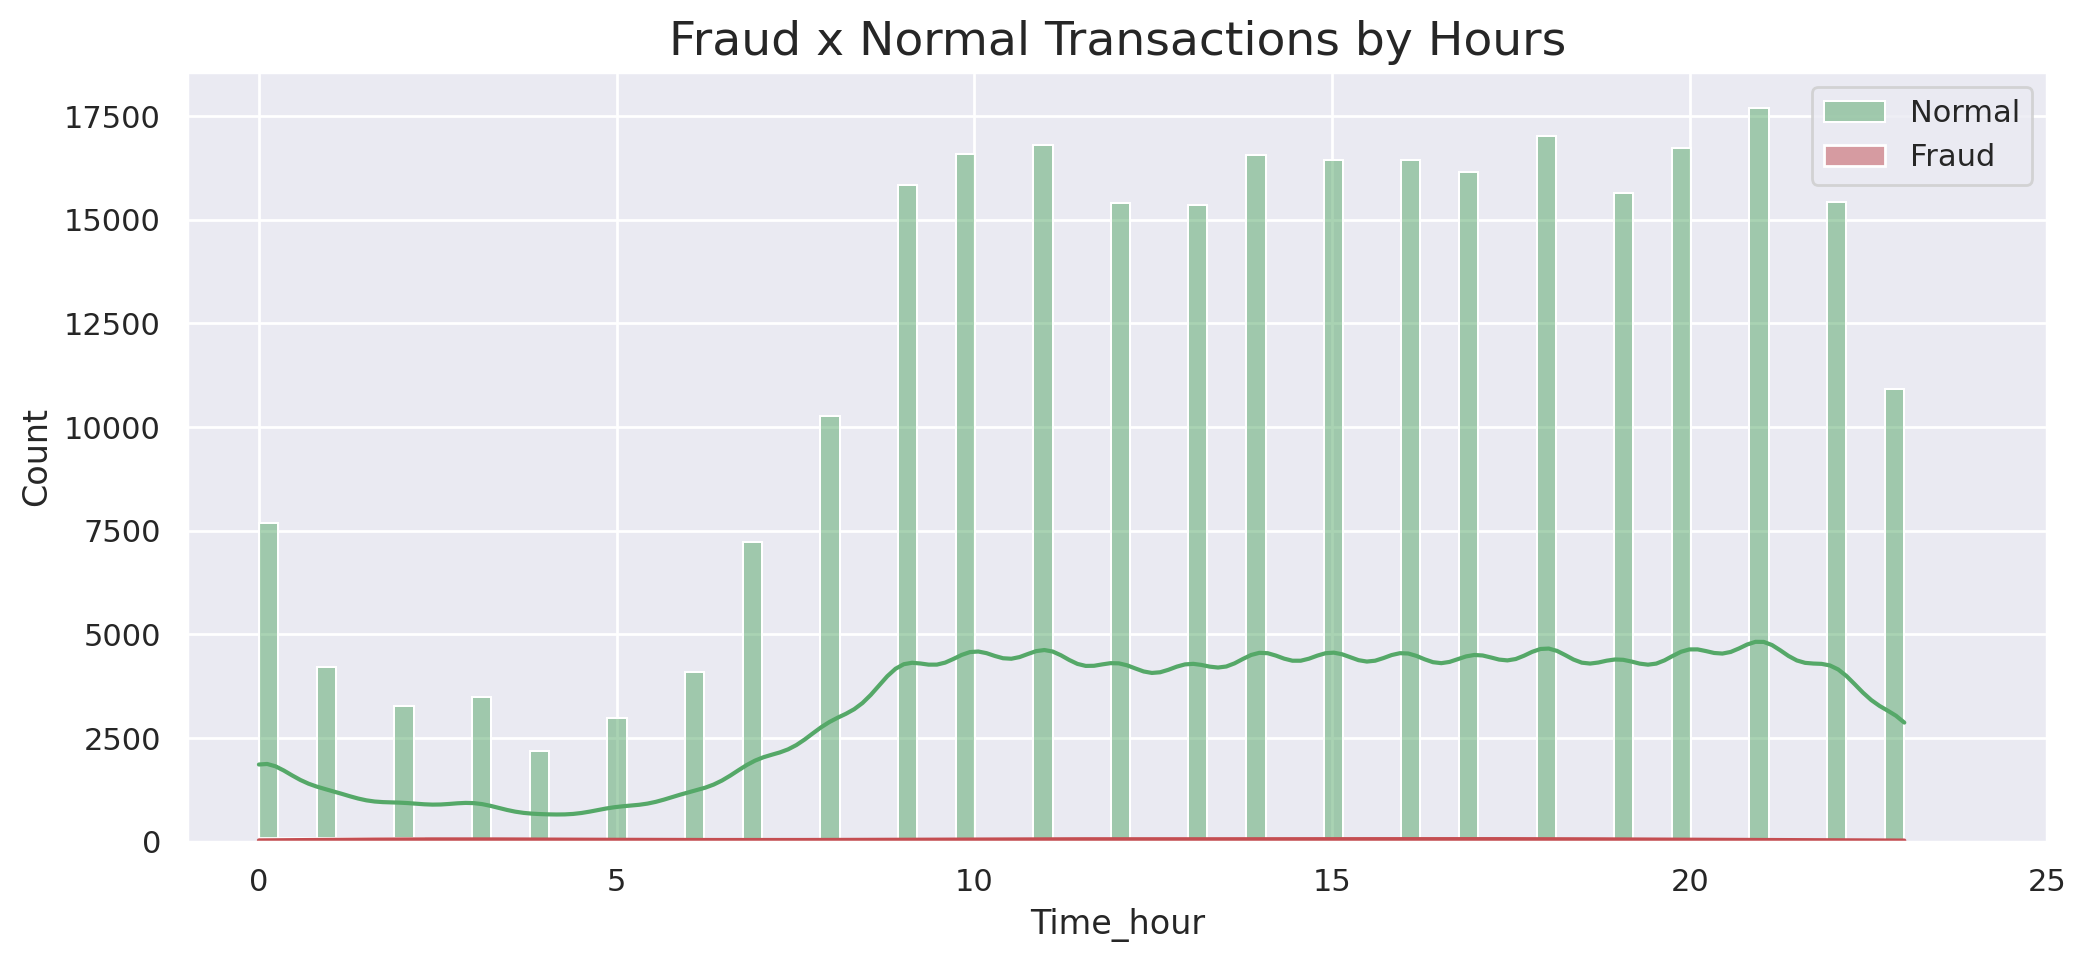

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(df[df['Class'] == 0]["Time_hour"],  color='g', kde=True, label='Normal')
sns.histplot(df[df['Class'] == 1]["Time_hour"], color='r', kde=True, label='Fraud')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1, 25])
plt.legend()
plt.show()

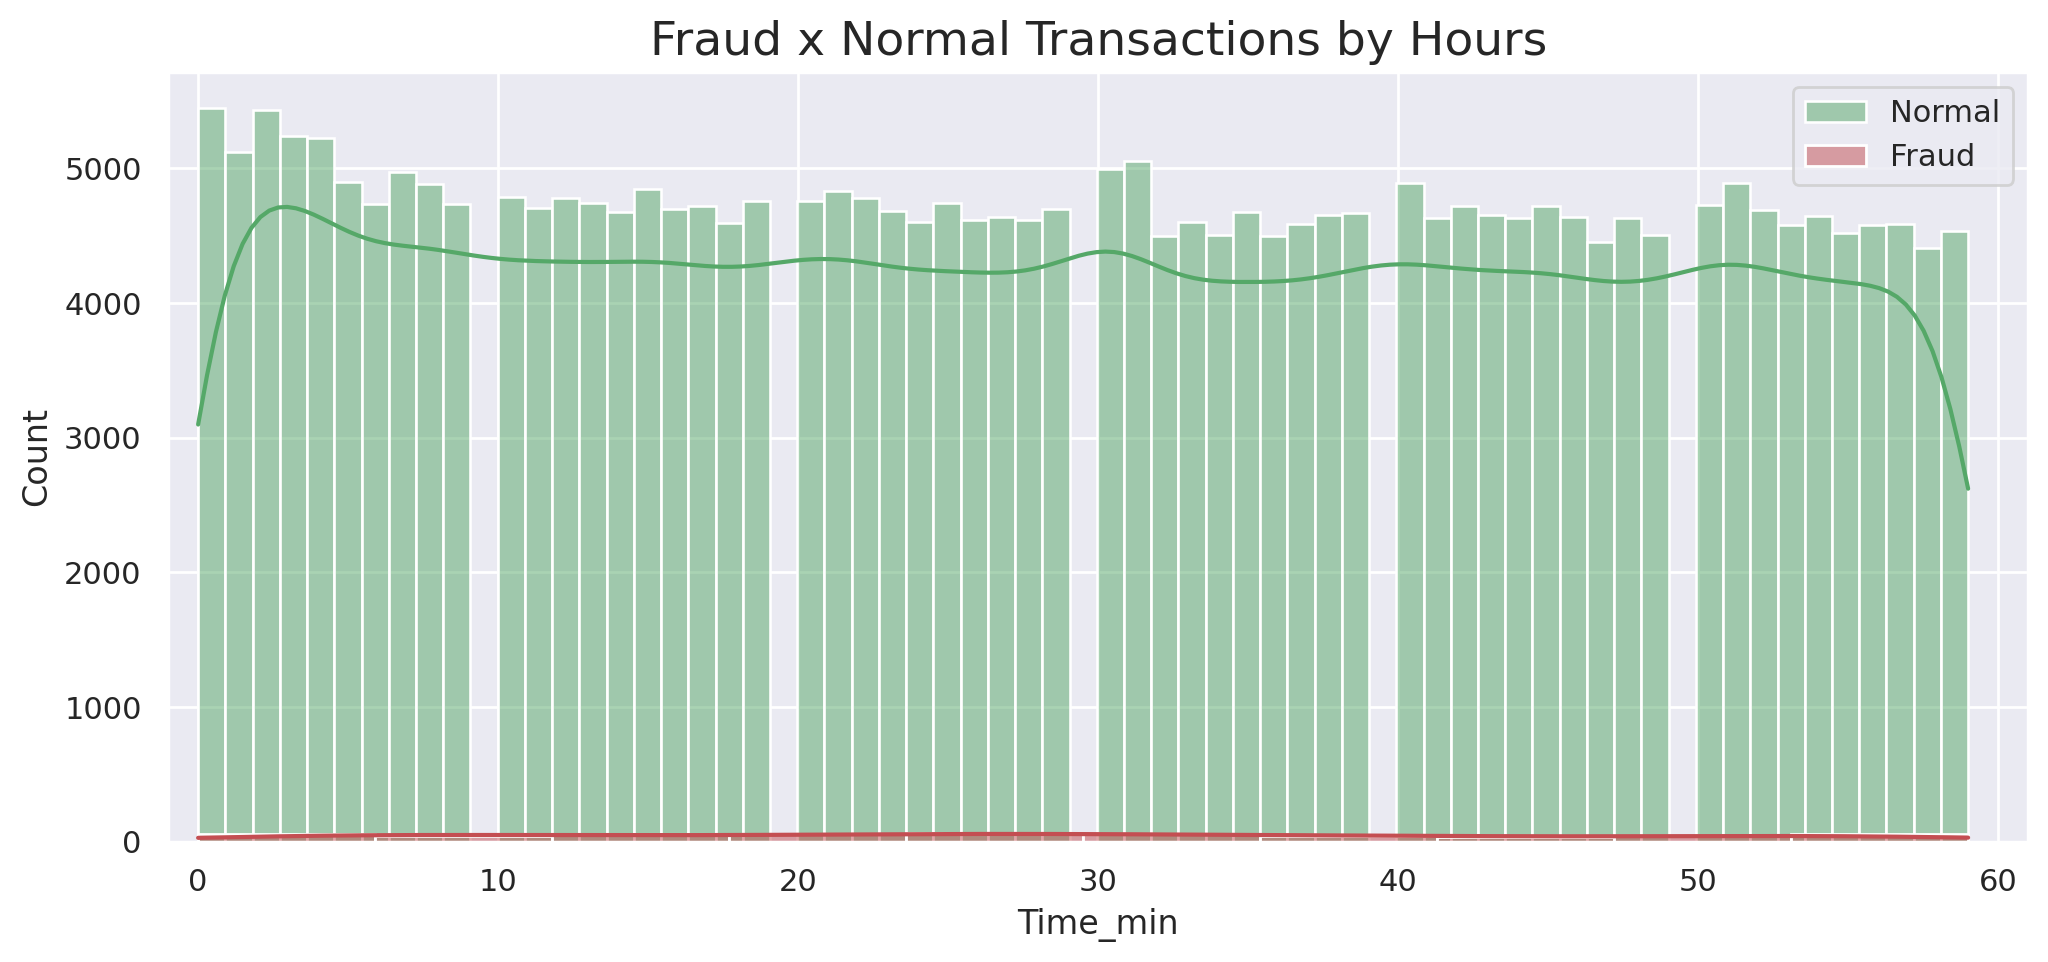

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df[df['Class'] == 0]["Time_min"],  color='g', kde=True, label='Normal')
sns.histplot(df[df['Class'] == 1]["Time_min"], color='r', kde=True, label='Fraud')
plt.title('Fraud x Normal Transactions by Hours', fontsize=17)
plt.xlim([-1, 61])
plt.legend()
plt.show()

<ipython-input-11-036521616790>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
<ipython-input-11-036521616790>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col][normals], bins = 50, color='r') #Will receive 

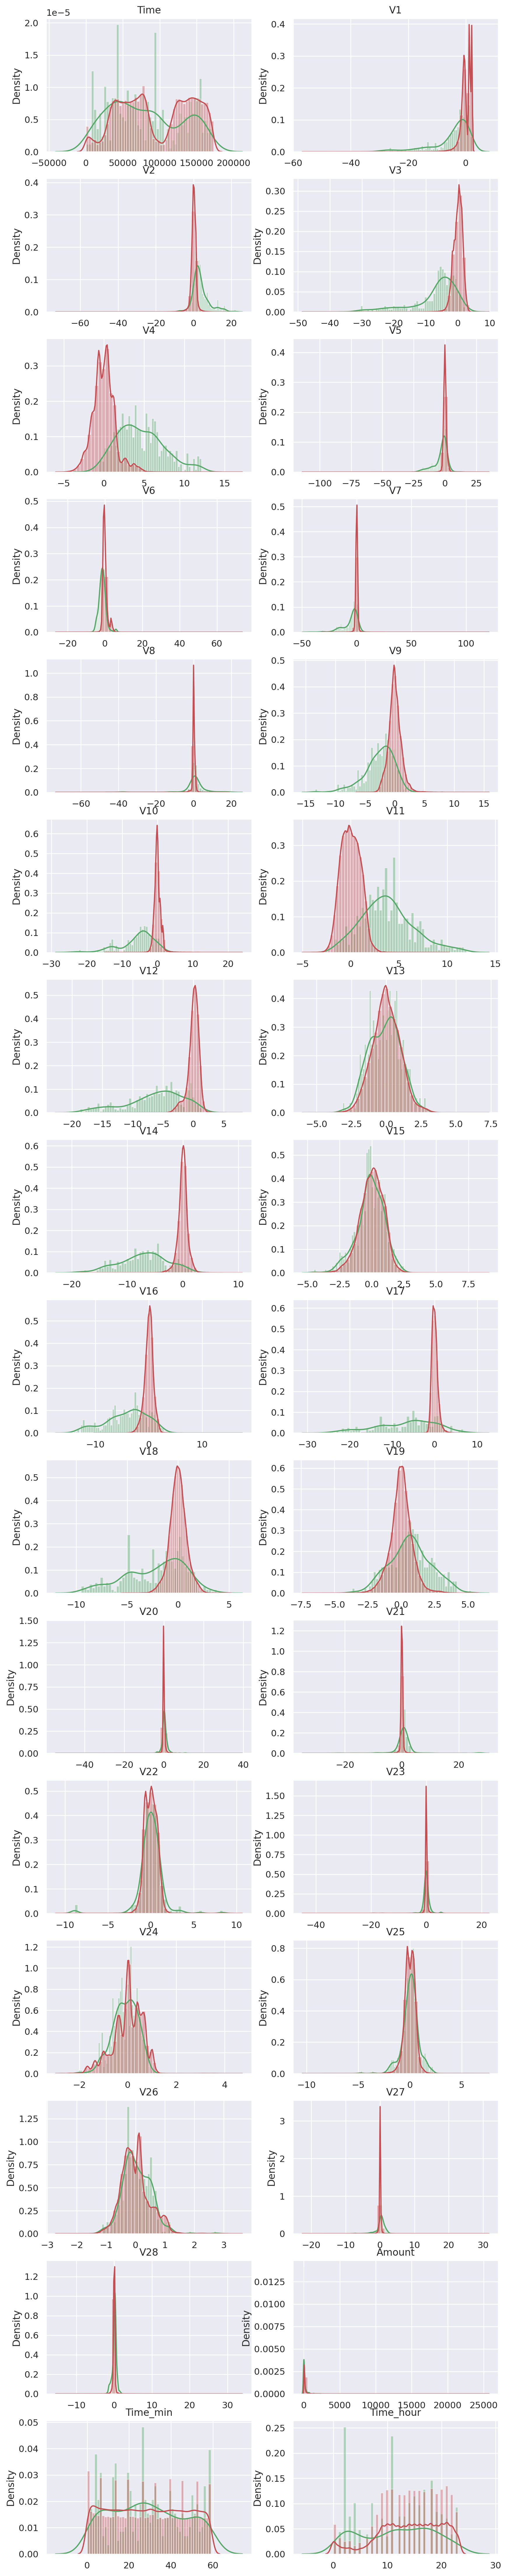

In [11]:
import matplotlib.gridspec as gridspec # to do the grid of plots #  gridspec work same as plt.subplots
columns  = df.iloc[:,df.columns  != 'Class'].columns
frauds = df.Class == 1
normals = df.Class == 0
grid = gridspec.GridSpec(17, 2)
plt.figure(figsize=(10,15*4))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(df[col][normals], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()

## Data Preprocessing

The columns listed below seems irrelevant

In [ ]:
df_selected = df.drop(['V15','V17','V24','V27','Time_hour','Time','Time_min'], axis = 1)

In [ ]:
df_selected.shape

(284807, 26)

### Data Splitting

In [ ]:
df_training, df_testing = train_test_split(df_selected,test_size = 0.2, random_state = 42,stratify = df_selected.Class)

In [ ]:
df_testing.Class.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

In [ ]:
train_data,validation_data,train_lable, validation_lable = train_test_split(df_training.loc[:,df_training.columns != 'Class'],df_training.Class,test_size = 0.2, stratify  = df_training.Class, random_state = 42)

### Scale Dataset

In [ ]:
##### here we are going to use min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_data)
train_data_normalised = data_scaled.transform(train_data)
validation_data_normalised = data_scaled.transform(validation_data)

test_data = df_testing.loc[:, df_testing.columns != 'Class']
test_lable = df_testing.Class
test_data_normalised = data_scaled.transform(test_data)

In [ ]:
print(f"train_data_normalised.shape: {train_data_normalised.shape}")
print(f"validation_data_normalised.shape: {validation_data_normalised.shape}")
print(f"test_data_normalised.shape: {test_data_normalised.shape}")

train_data_normalised.shape: (182276, 25)
validation_data_normalised.shape: (45569, 25)
test_data_normalised.shape: (56962, 25)


### Data Formatting

In [ ]:
# lets change the labels with boolean
train_lable,validation_lable, test_lable = train_lable.astype(bool), validation_lable.astype(bool), test_lable.astype(bool)

In [ ]:
# now  lets seperate the normal and fraud data out of training dataset
normal_train_data = train_data_normalised[~train_lable] # normal transactions out of train_data_normalised
normal_test_data = test_data_normalised[~test_lable] # normal transactions out of test_data_normalised
normal_validation_data = validation_data_normalised[~validation_lable]

In [ ]:
print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

181961
56864
45490


In [ ]:
fraud_train_data = train_data_normalised[train_lable]
fraud_test_data = test_data_normalised[test_lable]
fraud_validation_data = validation_data_normalised[validation_lable]

In [ ]:
print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

315
98
79


## Plot Data

**Normal Data**

In [ ]:
normal_train_data[0].shape

(25,)

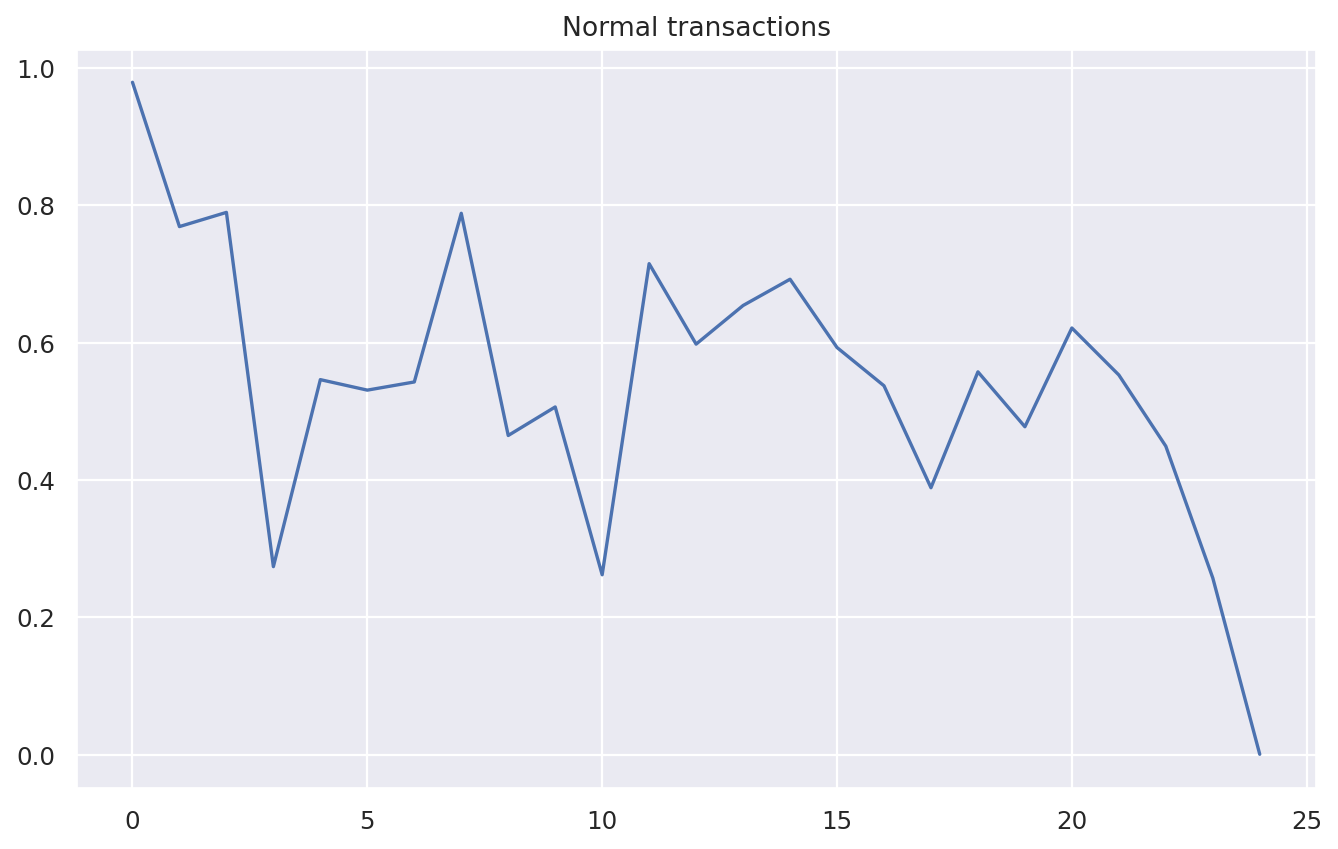

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
plt.plot(np.arange(25), normal_train_data[1])
plt.title('Normal transactions')

plt.show()

**Fraud Data**

In [ ]:
fraud_train_data[2]

array([0.86313861, 0.82236022, 0.60757087, 0.61178208, 0.51190726,
       0.5049505 , 0.46397614, 0.82124406, 0.30748151, 0.35697646,
       0.71079904, 0.29589388, 0.80944407, 0.30165222, 0.41927119,
       0.5202625 , 0.71738895, 0.39369728, 0.58151548, 0.53001624,
       0.61770724, 0.52496163, 0.50082531, 0.24652224, 0.        ])

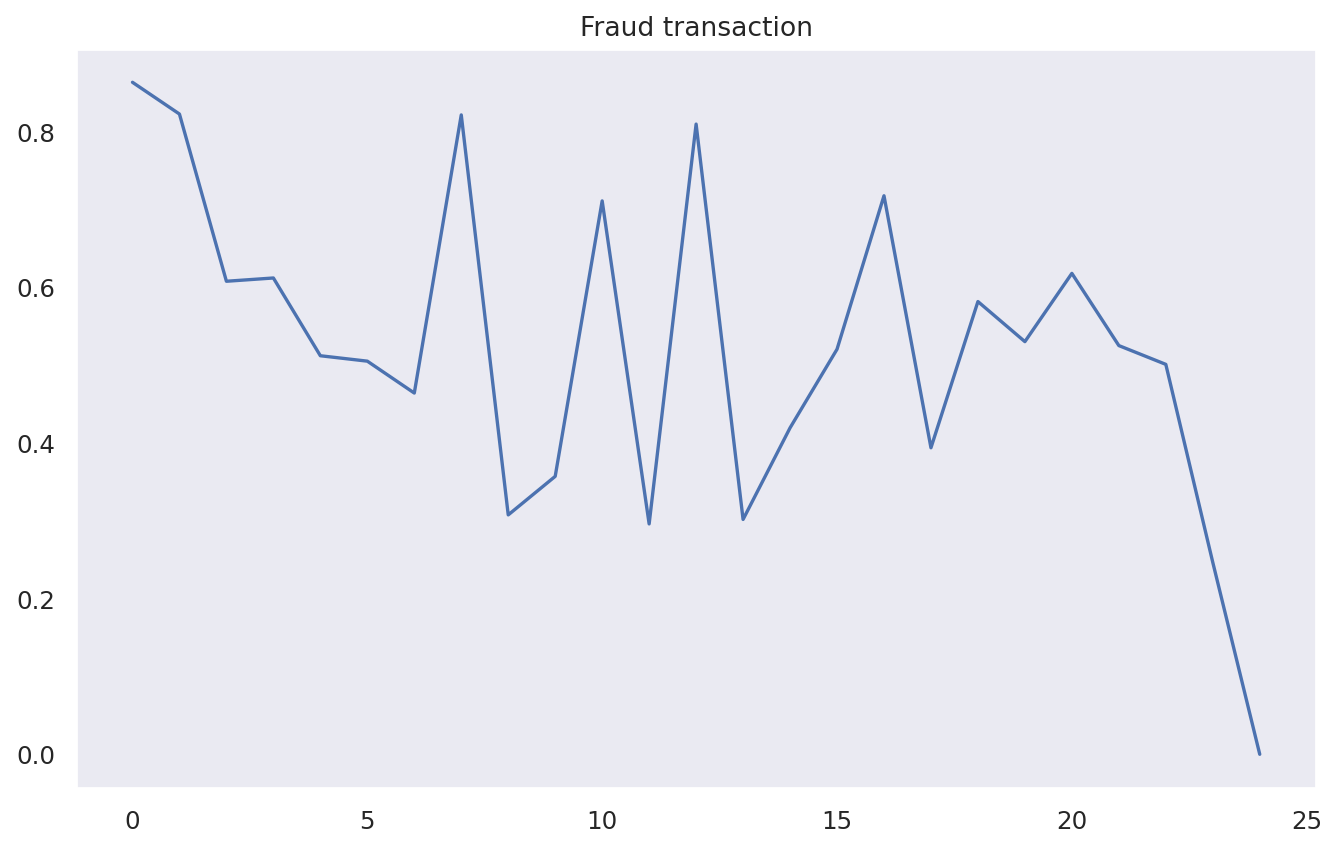

In [ ]:
#Lets plot one from fraud transaction
figure(figsize=(10, 6), dpi=80)

plt.plot(np.arange(25), fraud_train_data[2])
plt.grid()
plt.title('Fraud transaction')
plt.show()

## Auto-Encoder

**Encoder Design**

In [ ]:
n_features = len(train_data.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

**Decoder Design**

In [ ]:
decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

In [ ]:
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss=losses.MSE, optimizer=optimizers.Adam(), metrics=[metrics.mean_squared_error])

This took about 4 mins

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])

Epoch 1/100
5687/5687 [==============================] - 19s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.7271e-04 - val_mean_squared_error: 5.7271e-04
Epoch 2/100
5687/5687 [==============================] - 17s 3ms/step - loss: 5.6706e-04 - mean_squared_error: 5.6706e-04 - val_loss: 4.6406e-04 - val_mean_squared_error: 4.6406e-04
Epoch 3/100
5687/5687 [==============================] - 17s 3ms/step - loss: 5.0529e-04 - mean_squared_error: 5.0529e-04 - val_loss: 4.4238e-04 - val_mean_squared_error: 4.4238e-04
Epoch 4/100
5687/5687 [==============================] - 18s 3ms/step - loss: 4.7070e-04 - mean_squared_error: 4.7070e-04 - val_loss: 4.0180e-04 - val_mean_squared_error: 4.0180e-04
Epoch 5/100
5687/5687 [==============================] - 17s 3ms/step - loss: 4.4745e-04 - mean_squared_error: 4.4745e-04 - val_loss: 4.1738e-04 - val_mean_squared_error: 4.1738e-04
Epoch 6/100
5687/5687 [==============================] - 17s 3ms/step - loss: 4.3346e-04 - mean_sq

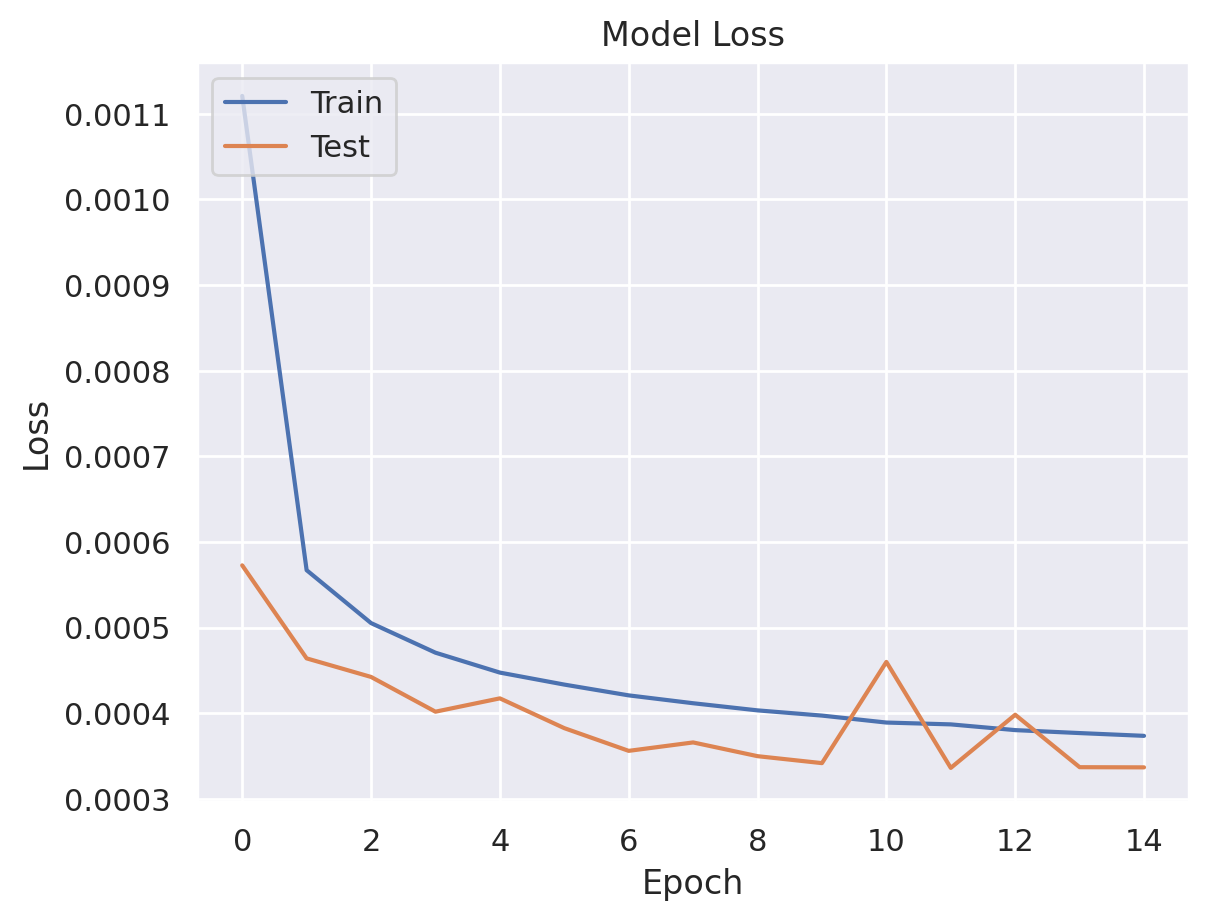

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  dec_img = autoencoder.predict(data) # this will decode or reconstruct
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(25), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

1777/1777 [==============================] - 3s 2ms/step


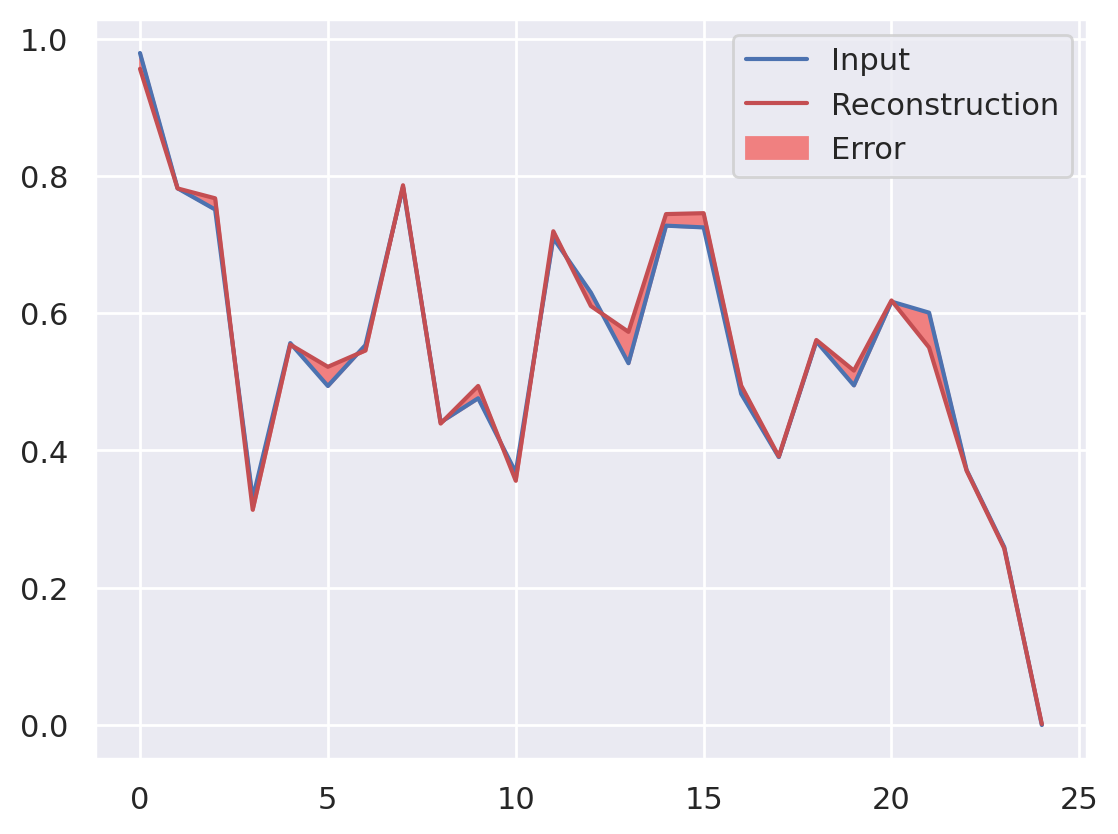

4/4 [==============================] - 0s 3ms/step


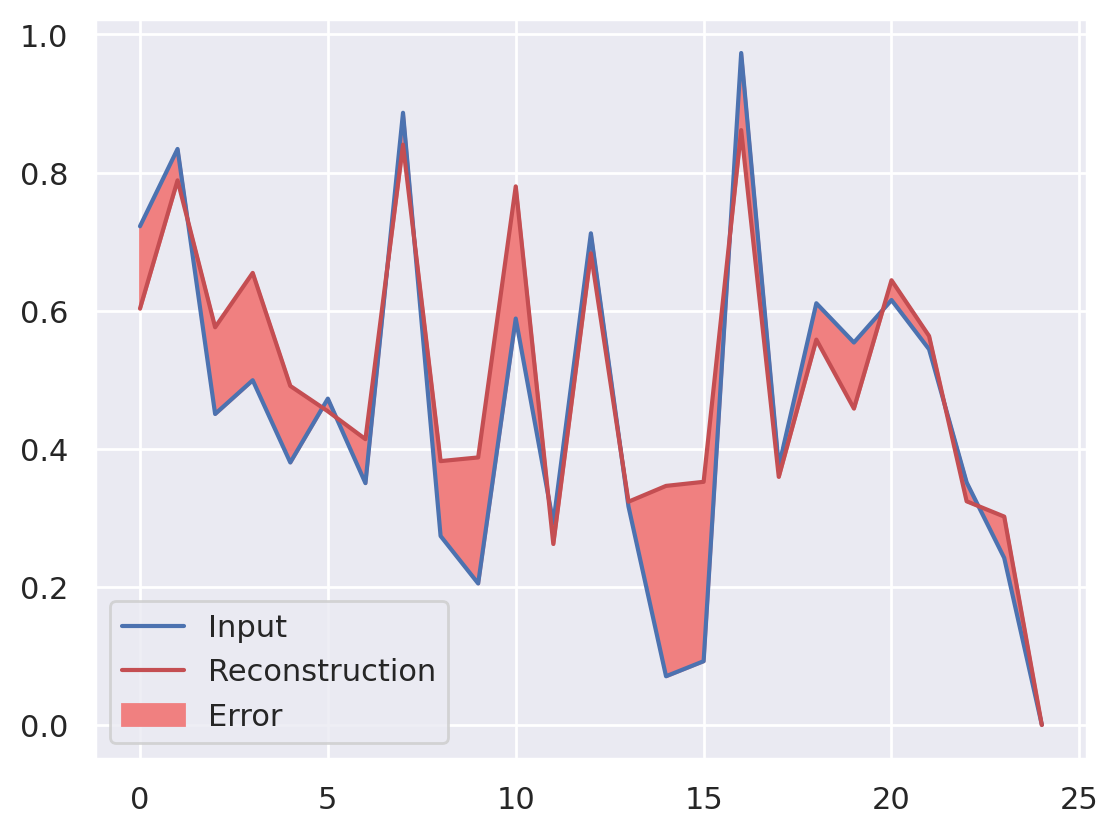

In [ ]:
plot(normal_test_data, 4) # here n shows the index of ecg samples
plot(fraud_test_data, 4)

## Find a threshold to detect Anomalies

In [ ]:
### calculating the train error  in legit transactions
reconstructed = autoencoder.predict(normal_train_data)
train_normal_loss = losses.mae(reconstructed, normal_train_data).numpy()
np.mean(train_normal_loss)

plt.hist(train_normal_loss, bins = 50)
plt.title('error normal train loss')
plt.show()

5687/5687 [==============================] - 8s 1ms/step


0.011665440663836913

10/10 [==============================] - 0s 3ms/step
0.056994176270862666


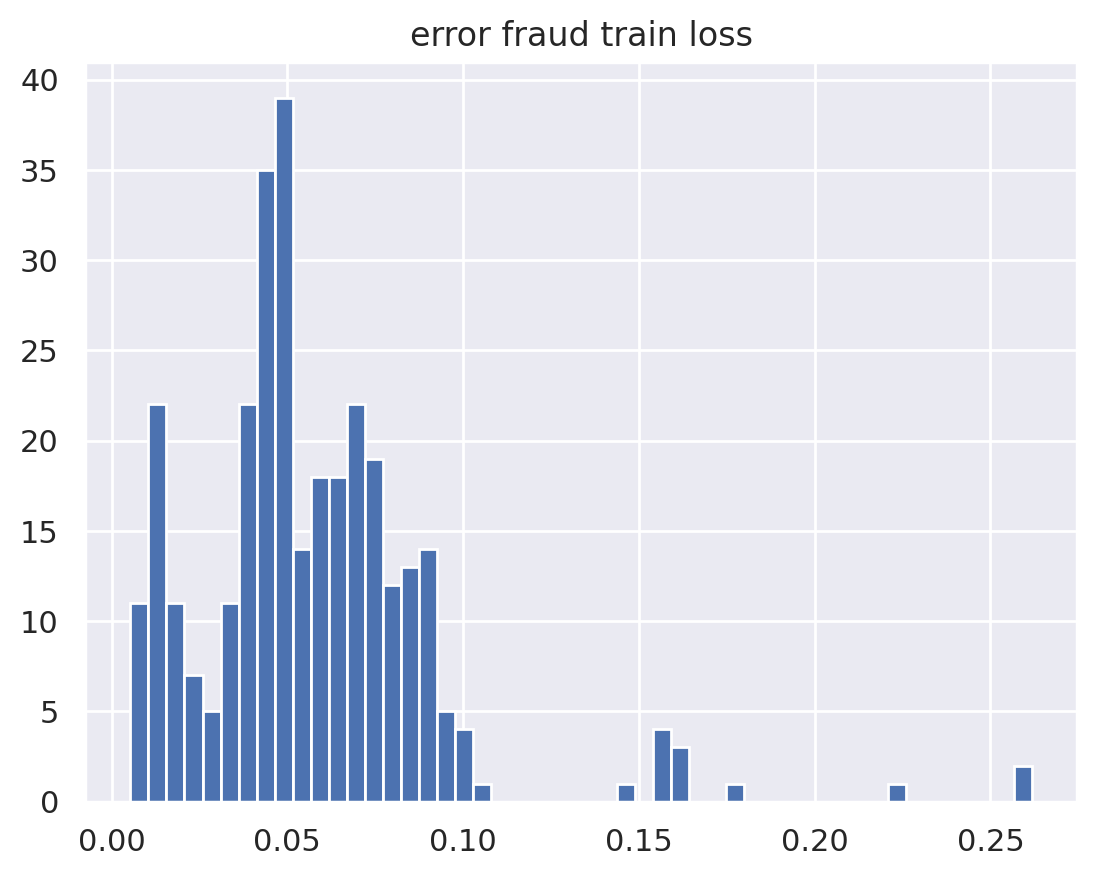

In [ ]:
### calculating the train error  in fraud transactions
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()

In [ ]:
Fraud = df.Class.sum()
total = len(df)
fraud_percentage = (Fraud/total)*100
fraud_percentage
# so lets say that 1% of transactions are fraud so lets find the threshold

0.1727485630620034

In [ ]:
# calcualting the error in the whole train data
reconstructed = autoencoder.predict(train_data_normalised)
train_loss = losses.mae(reconstructed, train_data_normalised).numpy()

5697/5697 [==============================] - 8s 1ms/step


There are two ways to set our threshold
1. set up by using percentile (suppose we have 2% of fraud transaction so our aim will be filter 2% probable data)
2. set up by using distribution and try to find the outliers

In [ ]:
# we are assuming that we have 1% of fraud transaction here
cut_off_1 = np.percentile(train_loss, 99)
cut_off_1

0.03580329744104729

In [ ]:
cut_off_2 = np.mean(train_loss) + 5*np.std(train_loss)
cut_off_2
# 2std division covers 97% of the distribution and here i have taken 3 std division

0.04438798079807685

if error is greater than this value we would say fraud transaction if lesser than cut-off means legitimate transaction

### Prediction on our TEST data

In [ ]:
reconstructed = autoencoder.predict(test_data_normalised)
errors = losses.mae(reconstructed,test_data_normalised)
len(errors)
predicted = []
for error in errors:
    if error > cut_off_1:
        predicted.append(1)
    else:
        predicted.append(0)

1781/1781 [==============================] - 3s 1ms/step


In [ ]:
np.sort(errors)[::-1]

array([0.17023848, 0.16082922, 0.15561536, ..., 0.00296099, 0.00284606,
       0.00258549])

In [ ]:
predicted_fraud_cases = np.array(predicted).sum()
actual_fraud_cases = test_lable.sum()
print('predicted_fruad_cases =>'.format(), predicted_fraud_cases, 'true fraud cases =>'.format(), actual_fraud_cases)

predicted_fruad_cases => 596 true fraud cases => 98


In [ ]:
# From booliean Map back to 1 and 0
true_lable = test_lable.map({True:1,False:0})

## Conclusion

In [ ]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_lable, predicted))
print(confusion_matrix(true_lable, predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.13      0.82      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.90      0.61     56962
weighted avg       1.00      0.99      0.99     56962

[[56348   516]
 [   18    80]]


4/4 [==============================] - 0s 4ms/step


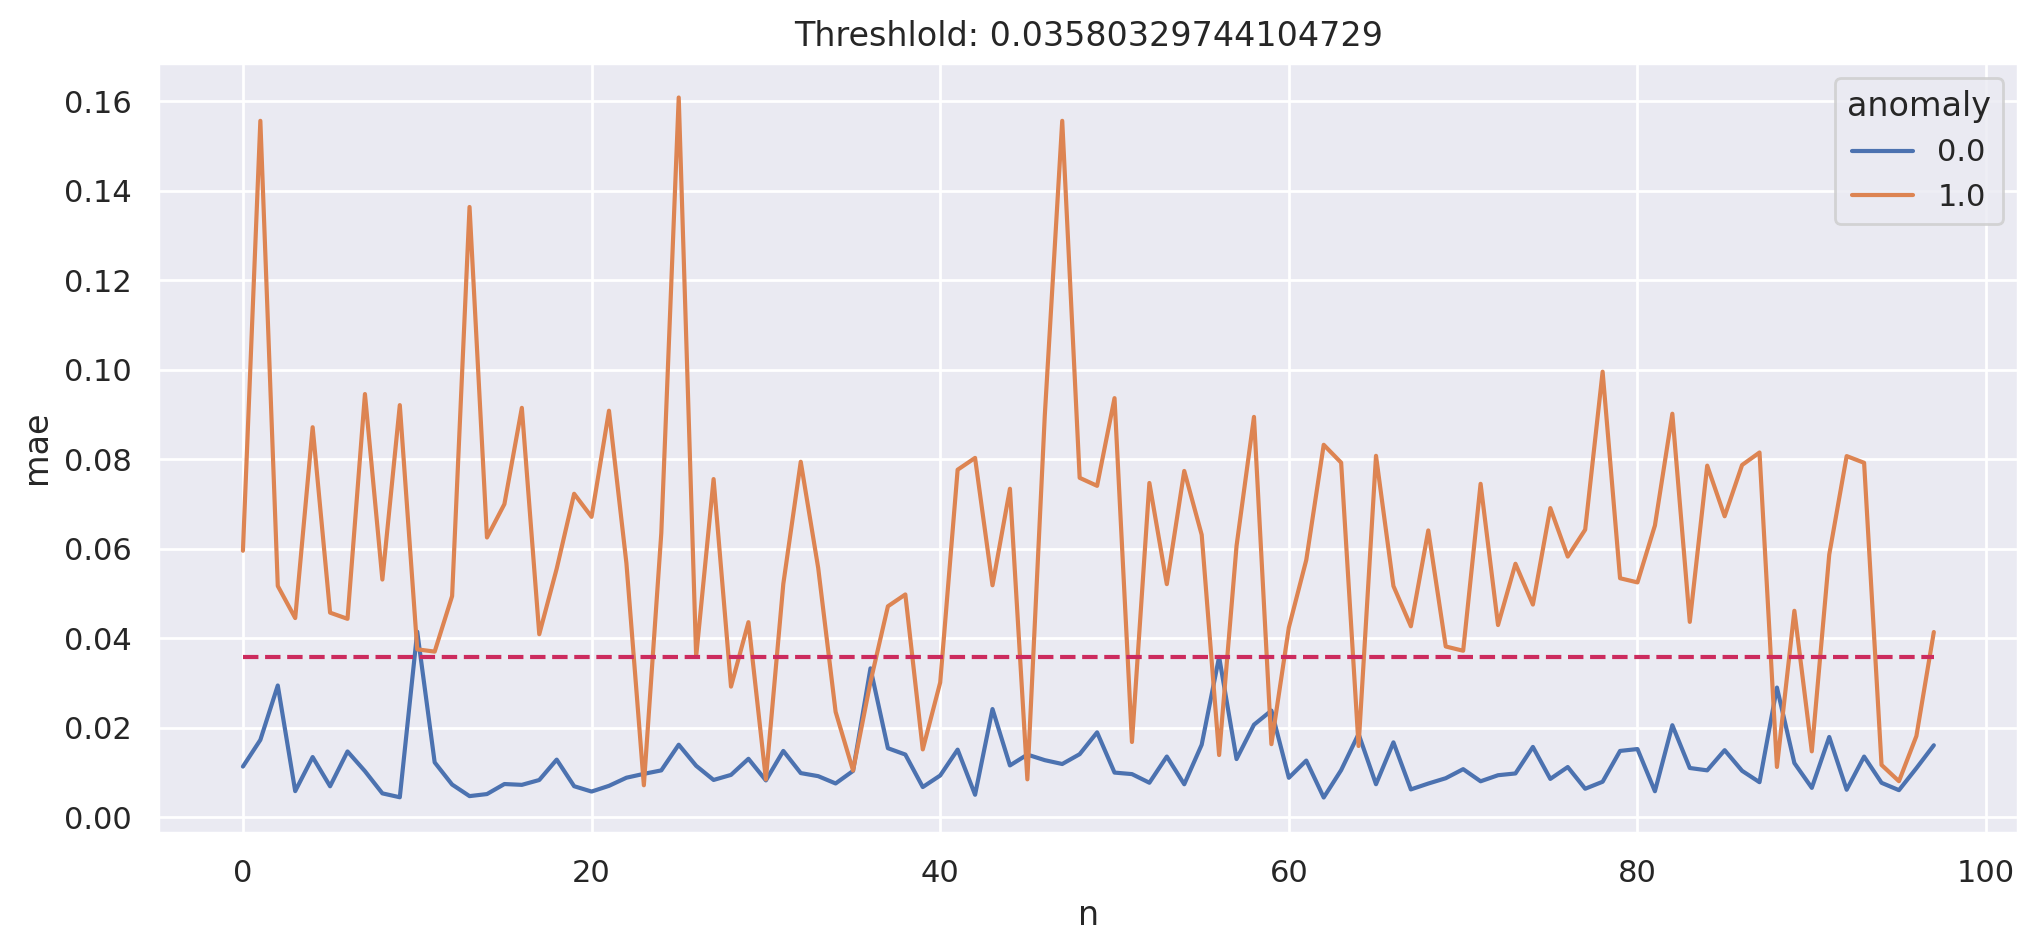

In [ ]:
from matplotlib import lines
plot_samples = 98
plt.figure(figsize=(12,5))

# normal event
n_features = 25
real_x = normal_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=real_x)
normal_events_mae = losses.mae(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mae': normal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})


# abnormal event
abnormal_x = fraud_test_data[:plot_samples]
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mae = losses.mae(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mae': abnormal_events_mae,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})
abnormal_events_df

mae_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mae_df.n, y=mae_df.mae, hue=mae_df.anomaly)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off_1),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off_1))
plt.show()

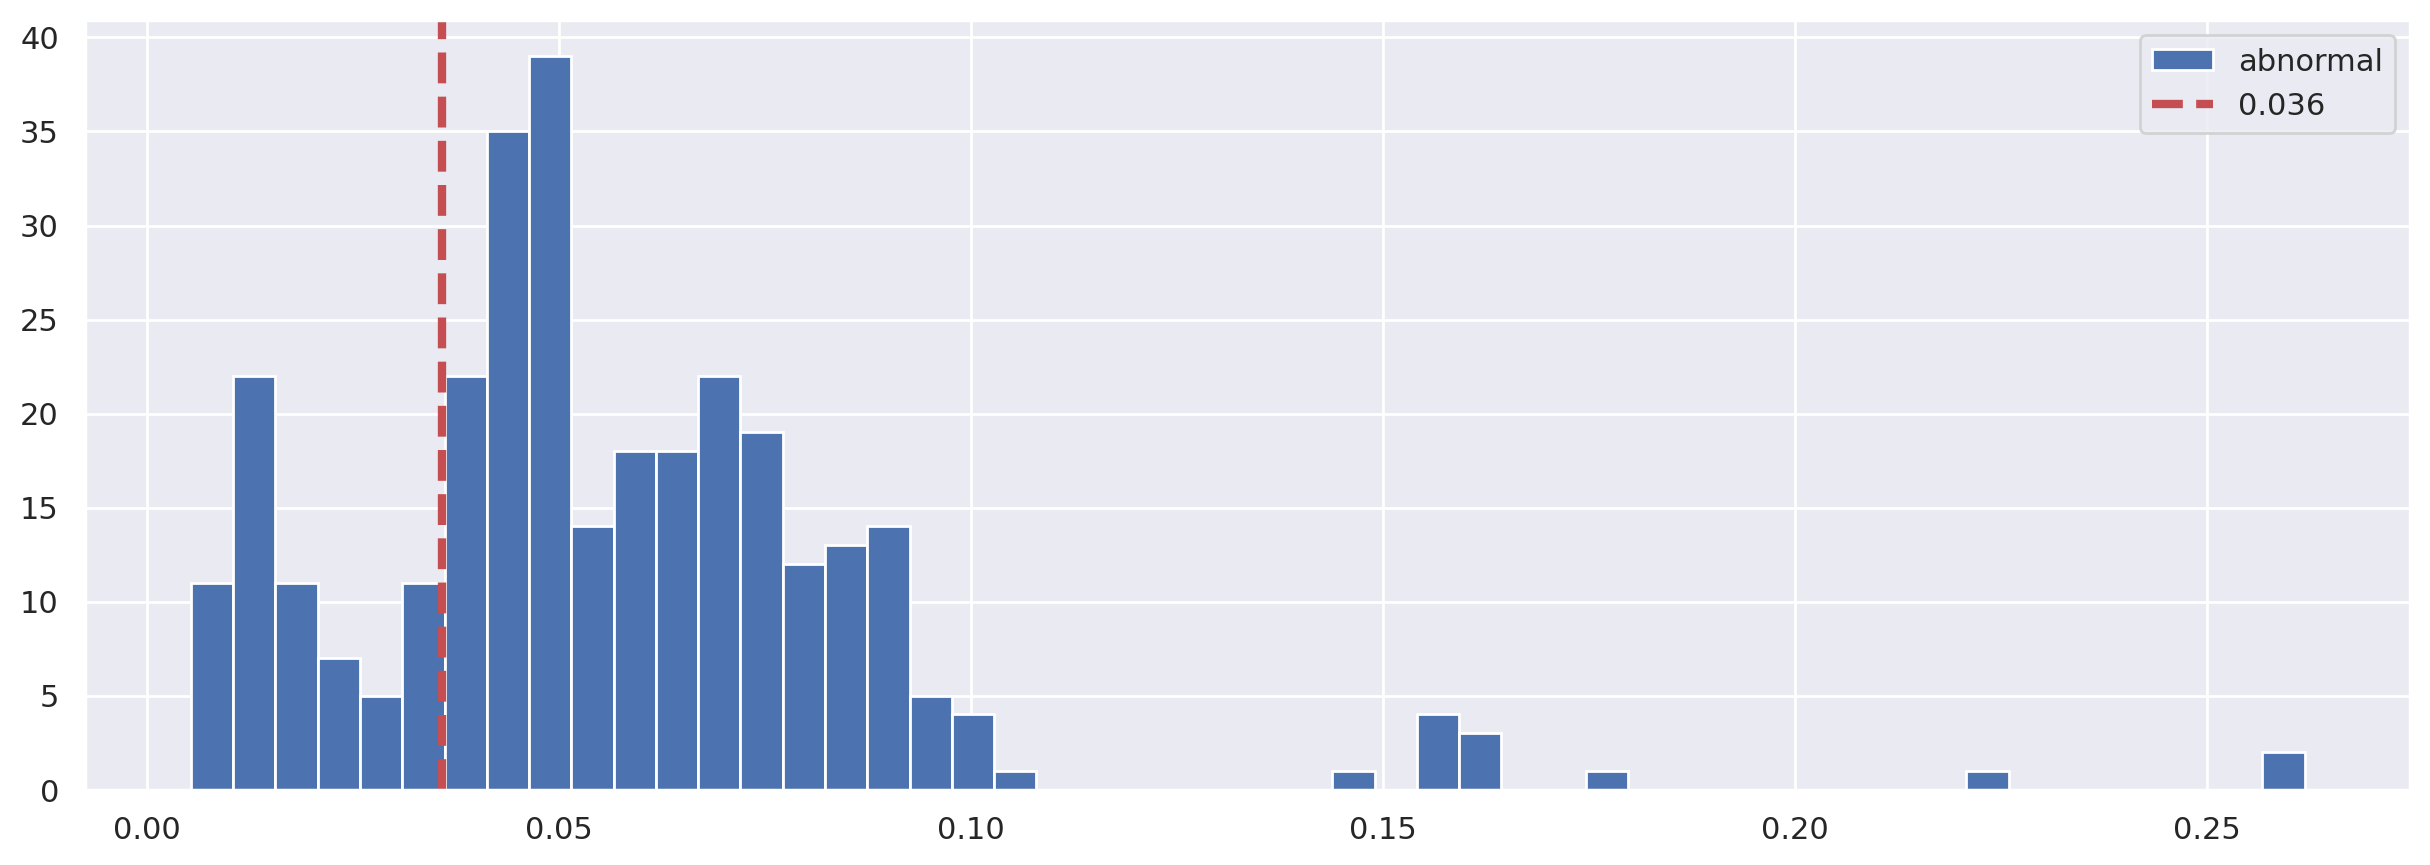

In [ ]:
plt.figure(figsize=(15,5))

# plt.hist(train_normal_loss, bins = 50, label = 'normal')
plt.hist(train_fraud_loss, bins = 50, label = 'abnormal')
plt.axvline(cut_off_1, color = 'r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(cut_off_1))
plt.legend(loc = 'upper right')
plt.show()